In [108]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from utils.models import GAM
from utils.independence import HSIC, dHSIC

# Causal discovery methods from scratch

## Additive noise model (ANM)

Peters et al. (2017) [Elements of Causal Inference](https://library.oapen.org/bitstream/id/056a11be-ce3a-44b9-8987-a6c68fce8d9b/11283.pdf) pp. 62-66

Hoyer et al. (2008) [Nonlinear causal discovery with additive noise models](https://proceedings.neurips.cc/paper/2008/file/f7664060cc52bc6f3d620bcedc94a4b6-Paper.pdf)

### Data

In [2]:
# Create data
x = np.random.randn(1000)
y = x**3 + np.random.randn(1000)

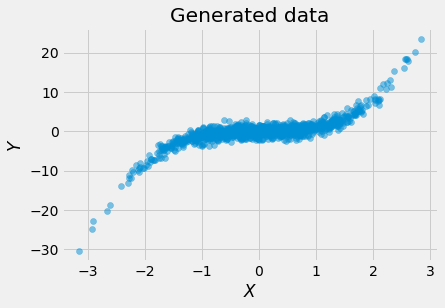

In [3]:
# Plot data
plt.scatter(x, y, alpha=.5)
plt.title('Generated data')
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.show()

### Fit the models

In [4]:
# Define params
n_splines = 200

# Instantiate the models 
model_xy = GAM(n_splines=n_splines)
model_yx = GAM(n_splines=n_splines)

# Fit the models
model_xy.fit(x.reshape(-1, 1), y)
model_yx.fit(y.reshape(-1, 1), x)

# Generate predictions
y_pred = model_xy.predict(x.reshape(-1, 1))
x_pred = model_yx.predict(y.reshape(-1, 1))

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


### Visualize the data and fitted models

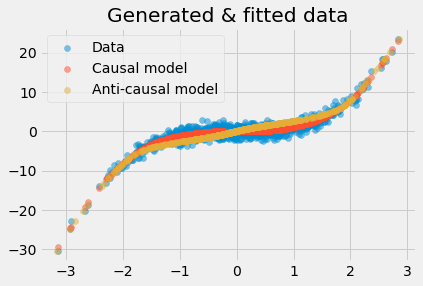

In [5]:
plt.scatter(x, y, alpha=.5, label='Data')
plt.scatter(x, y_pred, alpha=.5, label='Causal model')
plt.scatter(x_pred, y, alpha=.5, label='Anti-causal model')
plt.legend()
plt.title('Generated & fitted data')
plt.show()

### Plot residuals

In [6]:
residuals_xy = y - y_pred
residuals_yx = x - x_pred

In [7]:
np.savetxt('data/xy_model.csv', np.array([x, residuals_xy]).T, delimiter=',')
np.savetxt('data/yx_model.csv', np.array([y, residuals_yx]).T, delimiter=',')

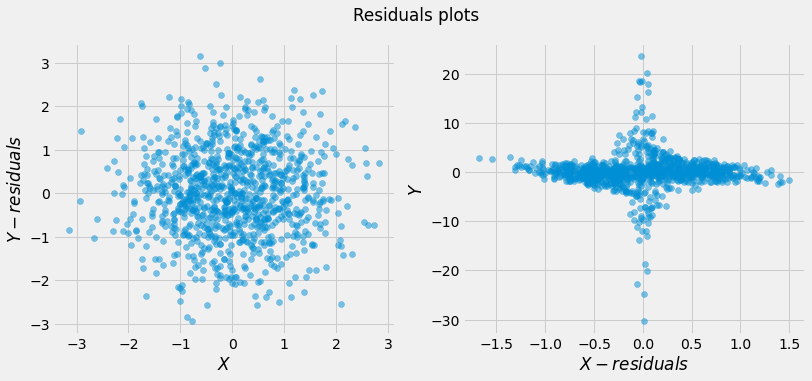

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(x, residuals_xy, alpha=.5)
plt.xlabel('$X$')
plt.ylabel('$Y-residuals$')

plt.subplot(122)
plt.scatter(residuals_yx, y, alpha=.5)
plt.xlabel('$X-residuals$')
plt.ylabel('$Y$')

plt.suptitle('Residuals plots')
plt.show()

### Approach 1: Independence test

Based on [Hilbert-Schmidt independence criterion](https://proceedings.neurips.cc/paper/2007/file/d5cfead94f5350c12c322b5b664544c1-Paper.pdf) (**HSIC**)

The test should be based on a $p$-value comparison. Direction with a larger the $p$ should be directional.

Nonetheless, the **HSIC** implementation that we use does not support $p$-value computations. 

We base our decision on the statistic returned by the test as this statistic has mainly a monotonic relationship with the $p$-value and so we treat the additive inverse of the statistic as a proxy for $p$-value. Note that we only care about relative difference between $p$-values here (not nominal values).

The plot below presents the results of an analysis between the HSIC statistic and $p$-value carried out in **R**.

<img src='img/HSIC_analysis.png' width=300>

In [9]:
print('Causal direction (HSIC):')
if HSIC(x, y - y_pred) < HSIC(y, x - x_pred):
    print('X -> Y')
else:
    print('Y -> X')

Causal direction (HSIC):
X -> Y


### Approach 2: Maximum likelihood

In [10]:
# X -> Y model likelihood
likelihood_xy = -np.log(np.var(x)) - np.log(np.var(residuals_xy))

# Y -> X model likelihood
likelihood_yx = -np.log(np.var(y)) - np.log(np.var(residuals_yx))


print('Causal direction (likelihood):')
if likelihood_xy > likelihood_yx:
    print('X -> Y')
else:
    print('Y -> X')
    
print(f'\nLikelihood X -> Y: {likelihood_xy}\nLikelihood Y -> X: {likelihood_yx}')

Causal direction (likelihood):
X -> Y

Likelihood X -> Y: 0.03233979248364446
Likelihood Y -> X: -1.314935130189519
